Aim: identify seasonality in inventories and alternative approaches to balance

Steps:
* ~~find seasonality in stocks~~
* ~~find seasonality in days cover~~
* **correlate imports vs fly / spread / flat price**
* tonne miles vs outright inventory levels, 
* if I can forecast increase in tonne miles can I have a direction on stocks

Conclusions
* supply cover has some mild seasonality too
* safer to user supply cover forecast, as this generally holds around 45 days
* apply forecast of supply cover, and work back into an imports number
* days cover vs total capacity is more stable
* apply a seasonal change element, and apply a trend element

Fcast
* step 1: take mean from 2017 as baseline, + Jan - Dec delta

In [21]:
from tshistory.api import timeseries
from seasonal_plot import seasonal_plot as snp
from seasonal_plot import generate_seasonal_frame as gns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import pandas as pd
from datetime import datetime

tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')

In [3]:
def convert_seasonal(series):
    df = series.to_frame()
    df = df.resample('MS').mean()
    df['year'] = df.index.year
    df['month'] = df.index.month
    return df.pivot(columns='year', index='month')

In [23]:
kpler_inv = "crude.kpler.oecd_europe.ending_stocks.mb.daily"
iea_inv = "crude.iea.oecd_europe.ending_stocks.kb.monthly"
iea_inv = "crude.iea.oecd_europe.commercial_stocks.kb.monthly"
cover = "crude.petroineos.oecd_europe.days_cover.monthly.forecast"
total_cap = "oil.petroineos.oecd_europe.cdu.capacity.kbd.daily"
av_cap = "oil.petroineos.oecd_europe.cdu.available_capacity.kbd.monthly"
saudi_crude_burn = "crude.jodi.saudi_arabia.crude_burn.kbd.monthly"

### saudi crude burn

In [33]:
crude_burn = tsa.get(saudi_crude_burn)
crude_burn.name = 'crude_burn'

In [36]:
# decompose_data = seasonal_decompose(crude_burn, model="additive")
# decompose_data.plot()
data = crude_burn.to_frame()

C:\Users\syedahmad\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\syedahmad\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


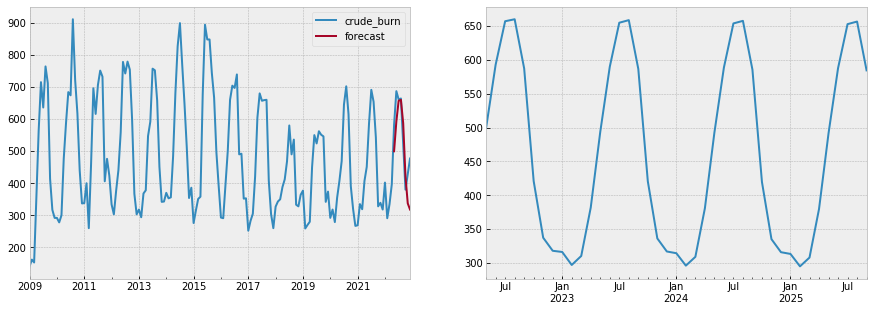

In [50]:
model=sm.tsa.statespace.SARIMAX(data['crude_burn'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
data['forecast']=results.predict(start=160,end=200,dynamic=True)
crude_burn_fcast = results.predict(start=160,end=200,dynamic=True)
fig, ax = plt.subplots(ncols=2)
data.plot(figsize=(15,5), ax=ax[0])
crude_burn_fcast.plot(ax=ax[1])

In [53]:
# tsa.update('crude.petroineos.saudi_arabia.crude_burn.kbd.monthly.forecast',crude_burn_fcast, author='Syed Ahmad')

### seasonality in inventories

In [5]:
inventories = tsa.get(iea_inv)
total_capacity = tsa.get(total_cap).resample('MS').mean()
av_capacity = tsa.get(av_cap)
days_cover = tsa.get(cover).loc[:'2022']
inv_delta = inventories.diff()
cover_total_cap = inventories.divide(total_capacity).dropna()
cover_av_cap =  inventories.divide(av_capacity).dropna()

print(f'{len(inventories)}, {len(total_capacity)}, {len(av_capacity)}')
print(f' totalcap {len(cover_total_cap)}, avcap {len(cover_av_cap)}')

215, 361, 361
 totalcap 215, avcap 215


In [6]:
index = pd.date_range(start=datetime(2022,1,1), end=datetime(2024,12,31), freq='MS')
days_cover = index.to_series()
days_cover.loc[index] = cover_total_cap.loc['2017':].mean()

In [7]:
seasonal = convert_seasonal(cover_total_cap.loc['2017':].diff())
seasonal['average'] = seasonal.mean(axis=1)

In [9]:
df = days_cover.to_frame()
df_2 = df.merge(seasonal['average'] , left_on=days_cover.index.month, right_index=True)
df_2.sort_index(inplace=True)
df_2['fcast'] = df_2[0]+df_2['average']

In [20]:
cover_fcast = df_2['fcast']
cover_seasonality = df_2['average']
cover_fcast.to_csv('test.csv')

In [18]:
cover_fcast.head()

2022-01-01    27.1162
2022-02-01    27.7458
2022-03-01     27.801
2022-04-01    27.5578
2022-05-01    27.4288
Name: fcast, dtype: object

In [19]:
# not working
# tsa.update(name='crude.iea.oecd_europe.commercial_days_cover.seasonality', series=cover_seasonality, author='Syed Ahmad')
# tsa.update(name='crude.iea.oecd_europe.commercial_days_cover.projection', series=cover_fcast, author='Syed Ahmad')

TypeError: argument of type 'float' is not iterable

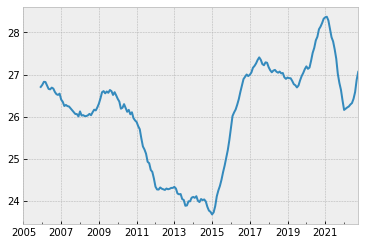

In [41]:
cover_total_cap.rolling(12).mean().plot()

#### SARIMAX model

In [125]:
data = cover_total_cap.to_frame()
# data = cover_av_cap.to_frame()
model=sm.tsa.statespace.SARIMAX(data[0],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\syedahmad\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\syedahmad\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


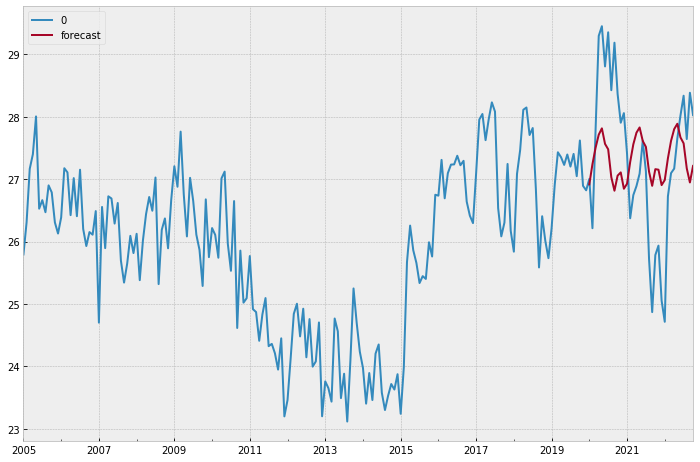

In [126]:
data['forecast']=results.predict(start=180,end=214,dynamic=True)
data.plot(figsize=(12,8))

#### standard seasonal decomposition

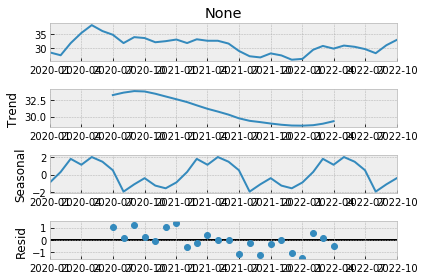

In [124]:
decompose_data = seasonal_decompose(cover_av_cap.loc['2020':], model="additive")
# decompose_data = seasonal_decompose(cover_total_cap.loc['2020':], model="additive")
decompose_data.plot()

In [182]:
decompose_data.trend.plot()

In [187]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(cover_total_cap, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.766044450855146
2. P-Value :  0.06329015798761786
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 212
5. Critical Values :
	 1% :  -3.4615775784078466
	 5% :  -2.875271898983725
	 10% :  -2.5740891037735847


#### seasonal decomposition using unobserved components

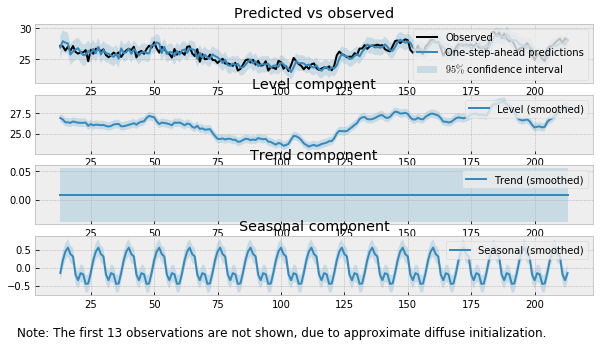

In [121]:
model = sm.tsa.UnobservedComponents(cover_total_cap.values, "lltrend", seasonal=12, )
result = model.fit()
result.plot_components(figsize=(10,5))

#### Plotting days cover vs total / available capacity as TS

In [175]:
fig, ax = plt.subplots(1,figsize=(10,5))
cover_total_cap.plot(ax=ax)
cover_av_cap.plot(ax=ax)
ax.set_title(label='days cover')
ax.legend(['Vs Total capacity', 'vs Available capacity'])

#### Plotting days cover as seasonal trends

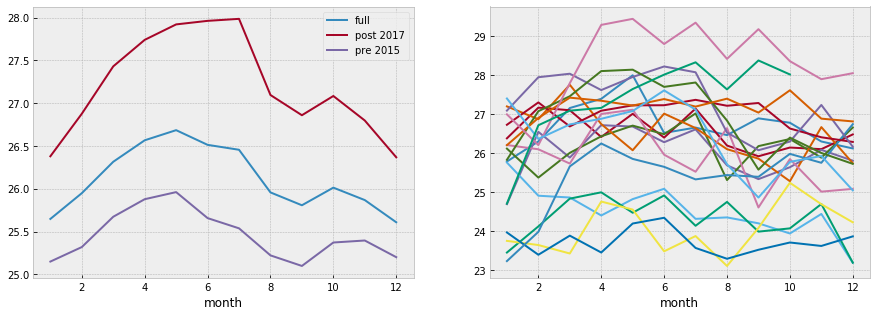

In [158]:
total_capacity_seasonal = convert_seasonal(cover_total_cap)
fig, ax = plt.subplots(1,2, figsize=(15,5))
total_capacity_seasonal.mean(axis=1).plot(ax=ax[0])
convert_seasonal(cover_total_cap.loc['2017':]).mean(axis=1).plot(ax=ax[0])
convert_seasonal(cover_total_cap.loc[:'2015']).mean(axis=1).plot(ax=ax[0])
total_capacity_seasonal.plot(ax=ax[1], legend=False)
ax[0].legend(['full', 'post 2017', 'pre 2015'])

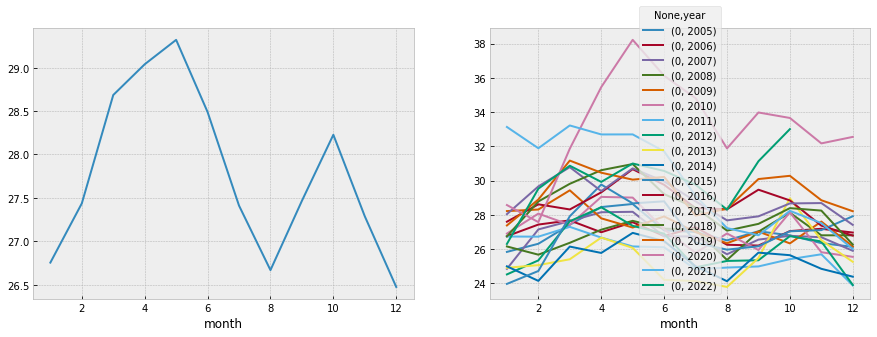

In [143]:
av_capacity_seasonal = convert_seasonal(cover_av_cap)
fig, ax = plt.subplots(1,2, figsize=(15,5))
av_capacity_seasonal.mean(axis=1).plot(ax=ax[0])
av_capacity_seasonal.plot(ax=ax[1])

In [134]:
snp(inventories,cutoff_year=2018, freq='M', agg='mean', interpolation=None)

c:\conda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\conda\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\conda\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


c:\conda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\conda\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\conda\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


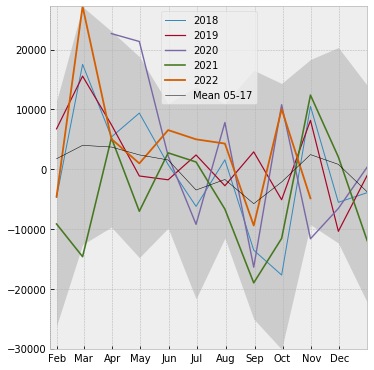

In [67]:
snp(inventories.diff(),cutoff_year=2018, freq='M', agg='mean', interpolation=None)

In [70]:
delta_seasonal = convert_seasonal(inventories.resample('MS').mean().diff())
delta_seasonal['average'] = delta_seasonal.mean(axis=1)
delta_seasonal['average'].plot(figsize=(20,10))

c:\conda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\conda\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\conda\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


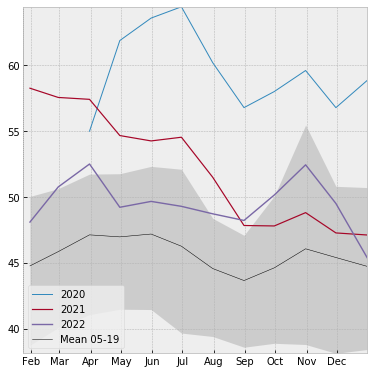

In [101]:
snp(days_cover,cutoff_year=2020, freq='M', agg='mean', interpolation=None)

In [96]:
cover_df = convert_seasonal(days_cover)
cover_df.mean(axis=1).plot()

In [99]:
cover_df.mean(axis=1).plot()

## spreads vs NWE imports

In [169]:
imports = tsa.get('crude.kpler.oecd_europe.imports.kbd.monthly')
imports_iea = tsa.get('crude.iea.oecd_europe.imports.kbd.monthly')
spread = tsa.get('price.platts.ice_brent_swap_spread.m01.usd_bbl.daily').resample('MS').mean()
df = pd.merge(spread,imports, left_index=True, right_index=True)

In [174]:
df.plot.scatter(x='price.platts.ice_brent_swap_spread.m01.usd_bbl.daily', y='crude.kpler.oecd_europe.imports.kbd.monthly')

In [171]:
df.head()

price.platts.ice_brent_swap_spread.m01.usd_bbl.daily  \
2014-01-01                                           0.407273      
2014-02-01                                           0.351500      
2014-03-01                                           0.315238      
2014-04-01                                           0.378000      
2014-05-01                                           0.674500      

            crude.kpler.oecd_europe.imports.kbd.monthly  
2014-01-01                                  4709.759700  
2014-02-01                                  6144.235286  
2014-03-01                                  6005.781548  
2014-04-01                                  6538.637967  
2014-05-01                                  6942.357935

In [116]:
projected_inventory = tsa.get("crude.iea.oecd_europe.inventory_forward_curve.kb.monthly")

In [119]:
inv_delta = projected_inventory.diff()

In [38]:
call = tsa.get("crude.petroineos.oecd_europe.call_on_imports.kbd.monthly")
actual_kpler = tsa.get("crude.kpler.oecd_europe.imports.kbd.monthly")
actual_iea_imports = tsa.get("crude.iea.oecd_europe.waterborne_imports.kbd.monthly")
druzbha = tsa.get("crude.petroineos.russia.oecd_europe.pipe_exports.kbd.monthly")
stock_change = tsa.get("crude.iea.oecd_europe.commercial_stocks.delta.kb.monthly")

print(f'kpler: {len(actual_kpler)}, IEA:{len(actual_iea_imports)},druzbha:{len(druzbha)}, call: {len(call)}, stck: {len(stock_change)}')

kpler: 109, IEA:154,druzbha:156, call: 143, stck: 213


In [39]:
predicted_stock_change = actual_iea_imports - call
predicted_stock_change.dropna(inplace=True)

In [43]:
pred_stock_change_kbbls = predicted_stock_change * predicted_stock_change.index.days_in_month

In [53]:
fig, ax = plt.subplots(1,figsize=(10,5))
pred_stock_change_kbbls.plot(ax=ax)
stock_change.plot(ax=ax)
ax.set_title(label='stock changes')
ax.legend(['predicted', 'actual'])

In [45]:
diff = pred_stock_change_kbbls - stock_change

In [47]:
diff.cumsum().plot()